# Project Topic
To receive full credit for this section, the learner should address the two questions below:
- Is there a clear explanation of what this project is about? 
- Does it give a clear description of generative deep learning models including Generative Adversarial Networks (GANs)?


This project is about generating music via deep learning. Specifically via LTSM (Long Term, Short Memory) Recurrent Neural Networks. The main goal is for my RNN to output and predict what note should come next. For instance, if it is given 4 notes, it should output the next note in the sequence based on the training data.

I used this excellent research paper as a reference https://people.idsia.ch/~juergen/blues/IDSIA-07-02.pdf which goes over musical compositions using LTSM RNNs.


# Data 
- Is there a clear description of the data, including the size, dimension, and structure? Some ideas for image data: you can include how many samples, number of channels (color or gray or more?) or modalities, image file format, whether images have the same dimension or not, etc.






The data we'll be using to generate our music are MIDI files. A MIDI file is a type of digital file used for storing music performance data. "MIDI" stands for Musical Instrument Digital Interface. It is a standardized format for communicating between musical devices like keyboards, synthesizers, or computers. Instead of containing actual sound recordings, MIDI files store instructions, like which notes to play, their timing, duration, and dynamics, as well as information about instrument types.

The data was initially from a free sample site of 93 MIDI files from 

External package requirements:
- ffmpeg
- fluidsynth
- musescore

In [1]:
import collections
import glob
import os

import IPython
import keras
import librosa
import matplotlib.pyplot as plt
import midi2audio
import numpy as np
import pandas as pd
import pretty_midi
import tensorflow as tf
from music21 import chord, converter, instrument, note, stream
from pydub import AudioSegment

# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

2025-04-22 23:38:19.651802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 23:38:19.781432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745379499.827382    1858 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745379499.840466    1858 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745379499.957697    1858 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DATA_DIR = "data/"
EXPORT_DIR = "export/"

In [3]:
# Get all MIDI file paths and check how many there are
midi_paths = glob.glob(f"{DATA_DIR}sample_pack/*.mid")
df_midi = pd.DataFrame(midi_paths, columns=["file_path"])
df_midi.describe()

,file_path
count,93
unique,93
top,data/sample_pack/1.mid
freq,1


Let's analyze how many instruments are in our MIDI files.

In [4]:
num_instruments = []
for file_path in df_midi["file_path"]:
    midi_file = pretty_midi.PrettyMIDI(file_path)
    num_instruments.append(len(midi_file.instruments))

df_midi["num_instruments"] = num_instruments
df_midi.describe()

/home/basilp/.local/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


,num_instruments
count,93.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


They're all one, which is fine, we can generate something from this. Let's hear some samples of what the sound like. 

In [5]:
fs = midi2audio.FluidSynth(sound_font="default.sf2", sample_rate=22050)
def convert_midi_to_wav(midi_file_path, dest_file_path = "", force = False):
    """
    Convert a MIDI file to wav

    :param midi_file_path: File path of the midi file.
    :param dest_file_path: Path of the destination file. Don't include the file type
    :return: wav file path name
    """
    if dest_file_path == "":
        dest_file_path = f"{EXPORT_DIR}wav/{os.path.splitext(os.path.basename(midi_file_path))[0]}"

    export_file_path_wav = f"{dest_file_path}.wav"
    # Don't waste compute time on existing files
    if os.path.exists(export_file_path_wav) and not force:
        print("File exists.")
    else:
        # Converting MIDI to .wav.
        fs.midi_to_audio(midi_file_path, export_file_path_wav)
    return export_file_path_wav

In [6]:
wav_paths = []
for file_path in df_midi["file_path"]:
    wav_paths.append(convert_midi_to_wav(file_path))
df_midi["wav_paths"] = wav_paths

File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.
File exists.

In [7]:
df_midi["wav_paths"].head()

0     export/wav/1.wav
1    export/wav/10.wav
2    export/wav/11.wav
3    export/wav/12.wav
4    export/wav/13.wav
Name: wav_paths, dtype: object

In [8]:
IPython.display.Audio(df_midi["wav_paths"][0])

In [9]:
IPython.display.Audio(df_midi["wav_paths"][10])

# Exploratory Data Analysis 
- EDA on images is open-ended, and it can be as simple as picking a few samples of images from each class, displaying them, and describing any findings. Some more ideas: you could plot histograms of those sample images and draw any conclusions. You could summarize image similarity by choosing a single metric to compare. The data may or may not have different image sizes, but you could mention that if the image sizes are different. Also, you can check how the range of the pixel intensities is distributed. You may also count labels (if multi-class or multi-label classification problem) to see if the labels are skewed, or you can plot a histogram of areas by segmentation labels, etc.
10 pts
- EDA goes above and beyond expectations: for example, in addition to picking a few sample images from each class, displaying them, and describing any findings, the learner includes several other histograms, appropriate visualizations, and detailed analysis of the dataset.





# Visualization

- Waveform
    - Displays amplitude over time
- Spectrogram
    - Display a frequency-based over time
- Mel Spectrogram
    - Display human perception of frequency based on the mel scale
- Chromagram
    - Displays intensity of pitch over time (harmony and melody)

In [10]:
def display_waveform(file_path):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def display_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

def display_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

def display_chromagram(file_path):
    y, sr = librosa.load(file_path)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()

def display_all_graphs(file_path):
    display_waveform(file_path)
    display_spectrogram(file_path)
    display_mel_spectrogram(file_path)
    display_chromagram(file_path)

We can see from the graphs below with out example audio sample of the amplitude and frequencies. We also see the frequencies of our audio tend to be around 0-6000 in frequency while anything higher is unhearable.

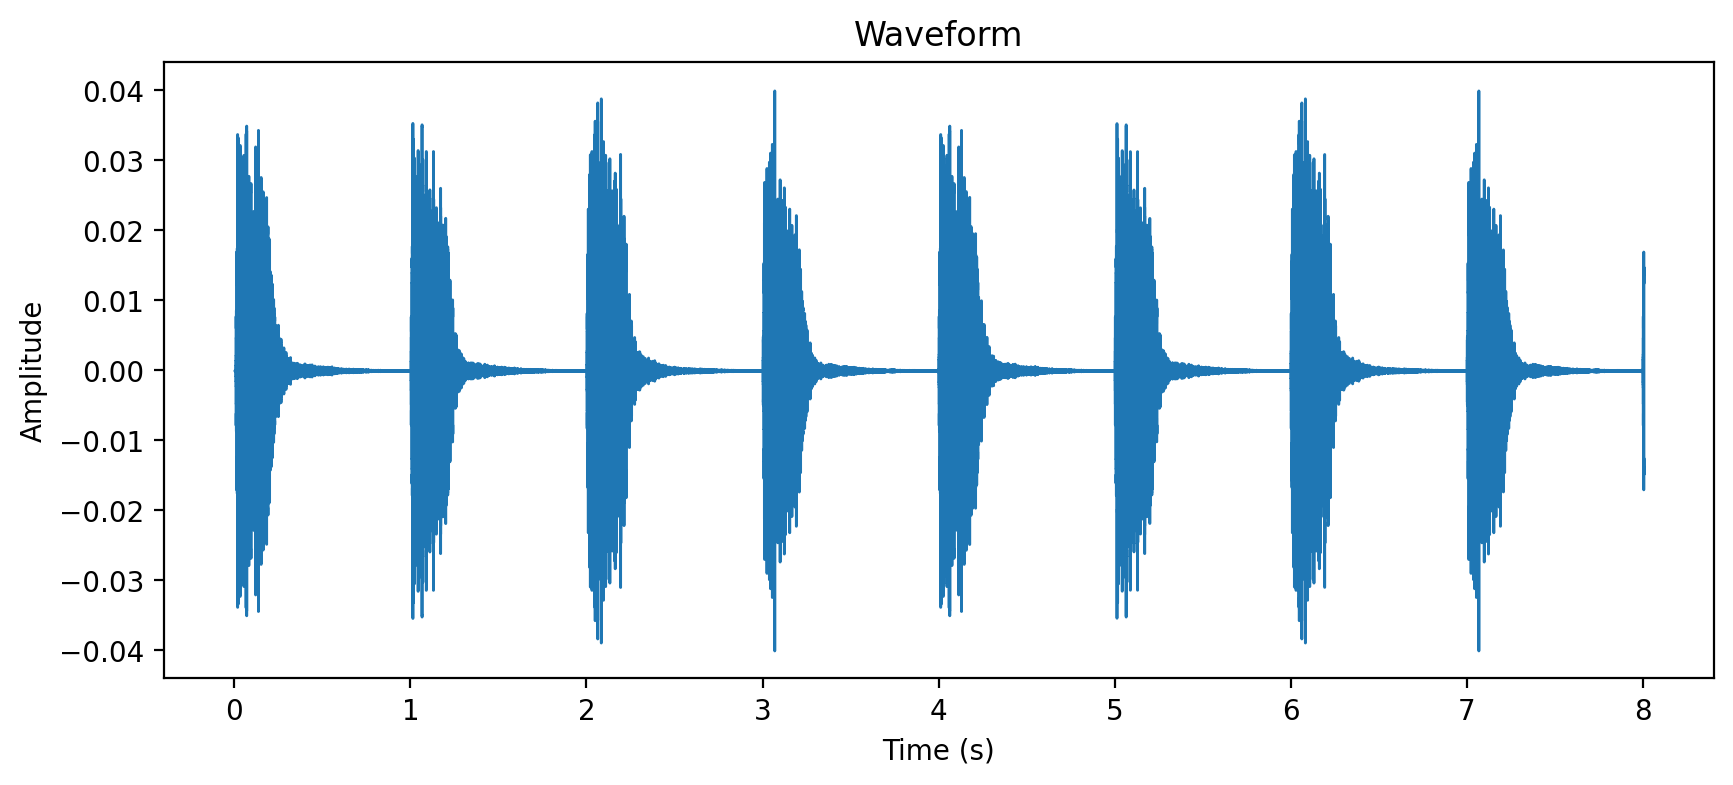

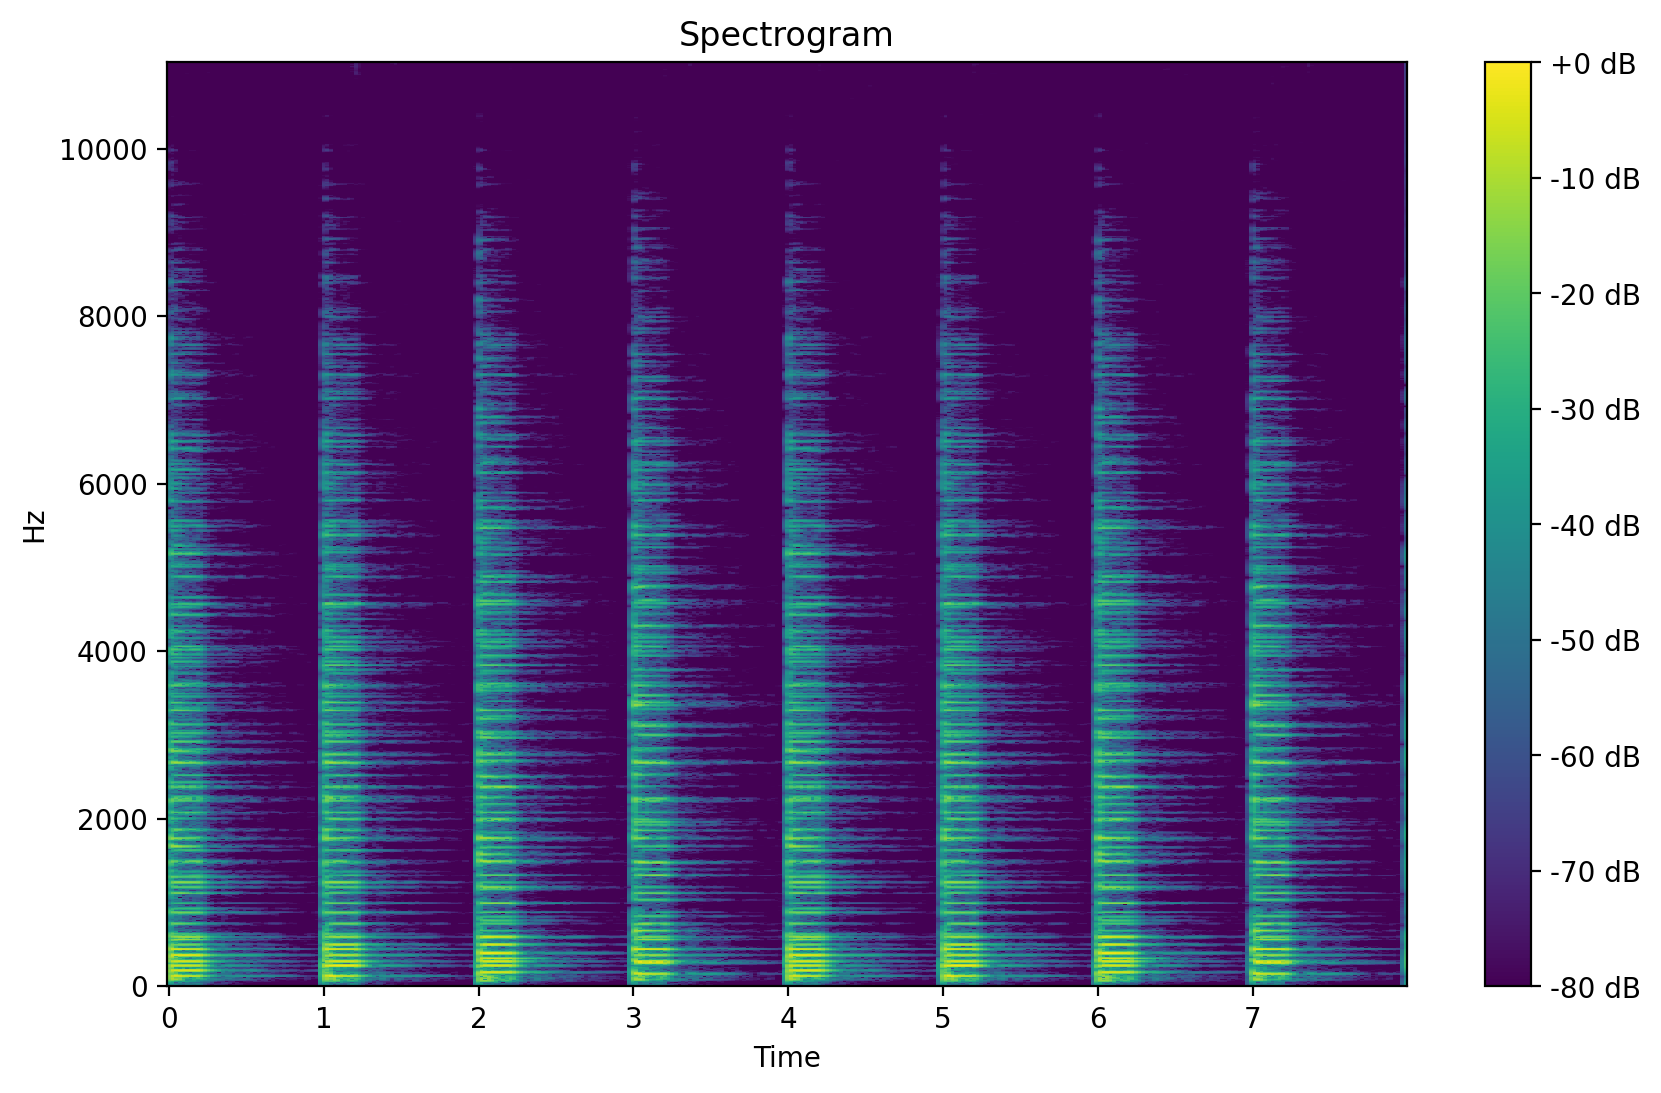

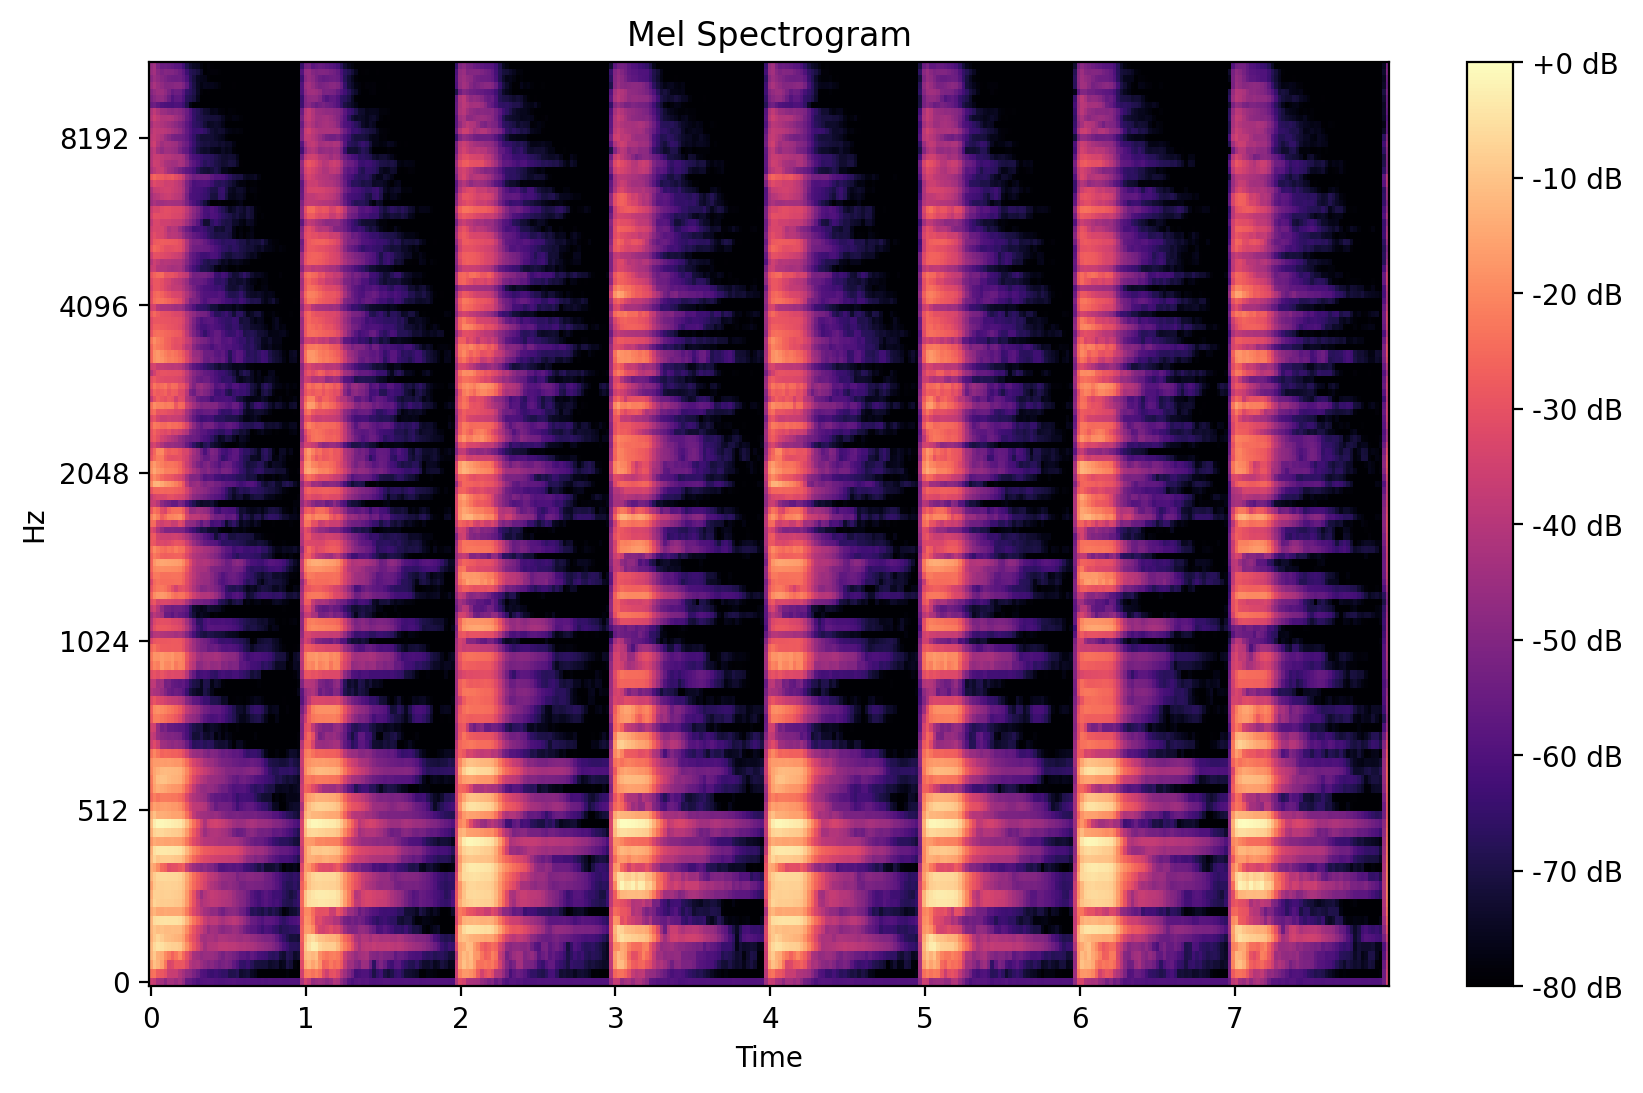

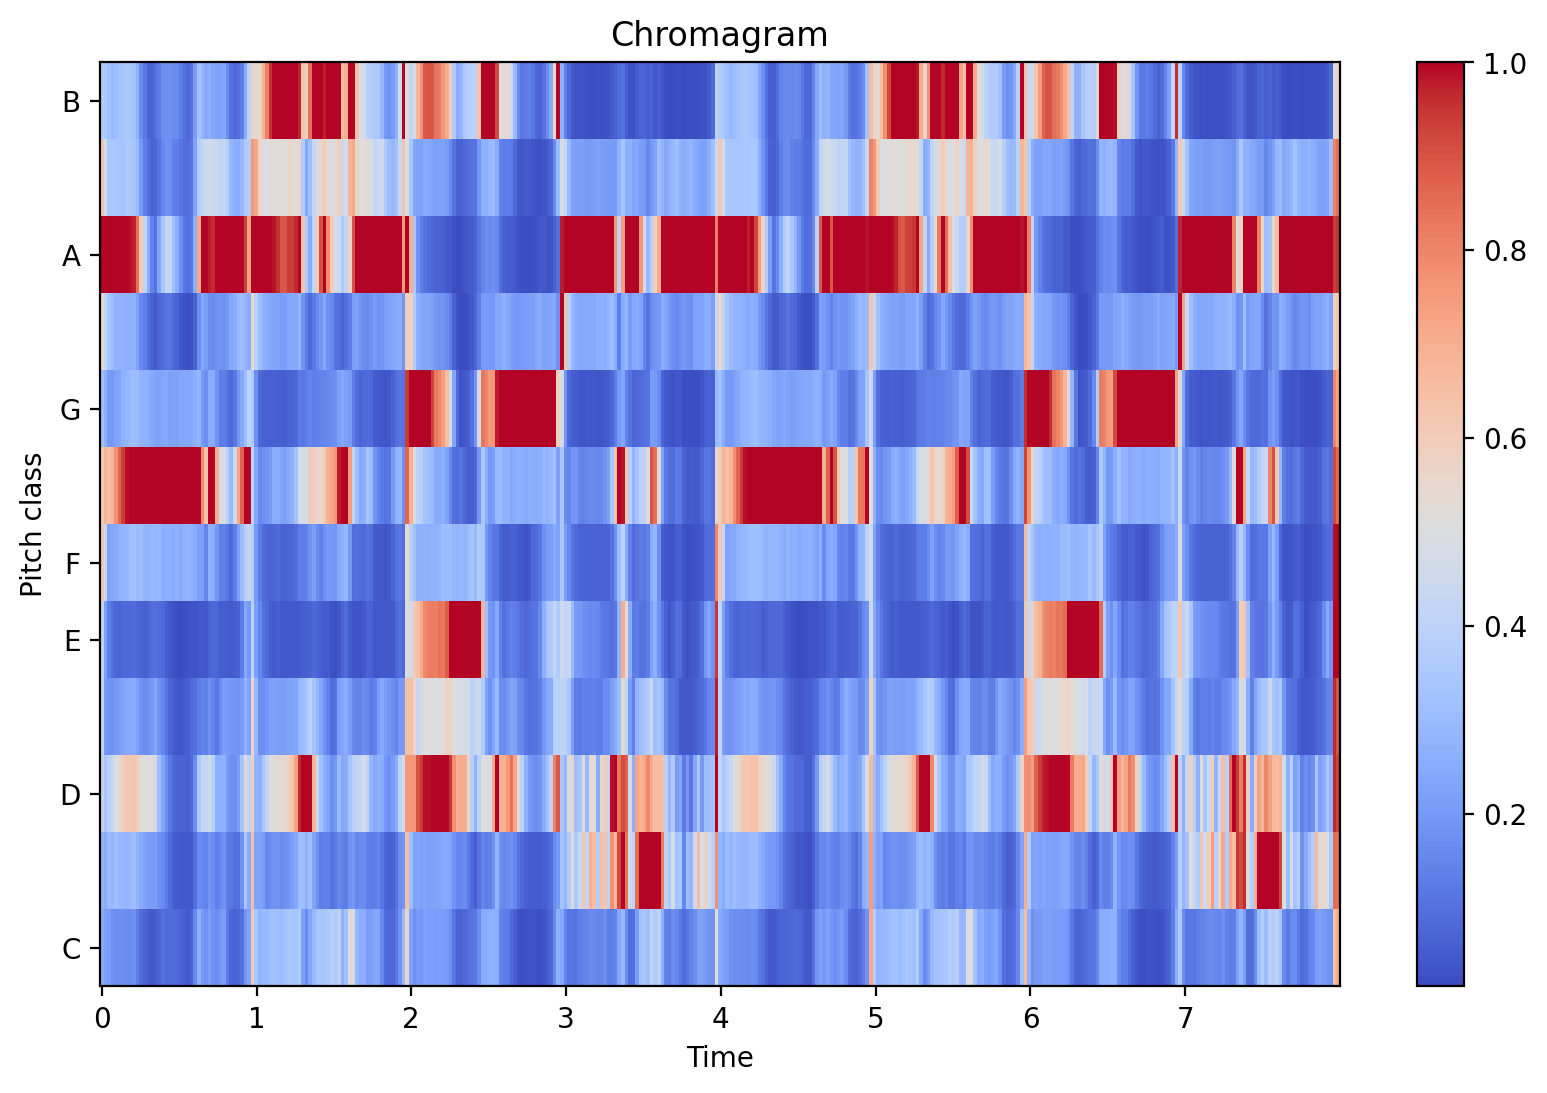

In [11]:
display_all_graphs(df_midi["wav_paths"][0])

In [12]:
def display_musical_sheet(file_path):
    # Load a MIDI file
    midi_file = converter.parse(file_path)

    # Create a Score object
    score = stream.Score()

    # Add the MIDI file content to the Score
    for part in midi_file.parts:
        score.append(part)

    # Display the musical sheet
    score.show()

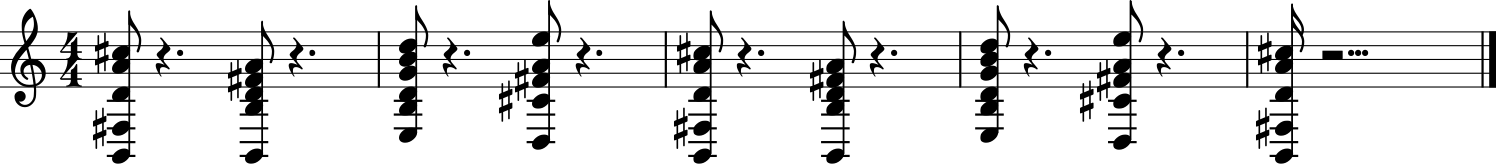

In [13]:
display_musical_sheet(df_midi["file_path"][0])


# Model Architecture
- Does it describe the model architecture and explain why the learner believes a specific architecture/loss function is suitable for the problem? 
- Did the learner tune the hyperparameters? 
- Did the learner compare multiple architectures/loss functions?
- Note, when you evaluate, don't just base your score on the complexity of the model/technique or performance of the model alone. Base your score on how the learner demonstrates understanding by explaining the concepts and why they chose particular methods/techniques.



The model architecture I chose was Long Short-Term Memory Recurrent Neural Networks or LSTM RNNs for short. They are a type of deep learning model designed to process and analyze sequential data. Unlike traditional RNNs (Recurrent Neural Networks), LSTMs excel at handling long-term dependencies in sequences. This is achieved by their unique structure, which includes specialized components—called gates—that regulate the flow of information and selectively remember or forget parts of the input data. This design addresses the problem of vanishing gradients in traditional RNNs, allowing LSTMs to better retain and utilize relevant information over longer sequences.

How they can be used to generate music:
LSTM RNNs can be applied to music generation by learning patterns and structures within existing musical compositions. Here's an overview of how this works:

Training Phase: The LSTM is fed sequences of notes or musical data (e.g., MIDI files) and trained to predict the next note or sequence based on the given input. It learns musical structures, harmonies, rhythms, and dynamics over time.

Generation Phase: Once trained, the LSTM can generate new music by providing it with a starting sequence, or "seed." The model predicts subsequent notes or musical elements, creating an original composition while maintaining coherence and flow.

Applications: LSTM-generated music can be used in various creative contexts—video game soundtracks, background music for films, personalized compositions, or even experimental genres.

We;re going to grab all the notes from all of our MIDI files in order to train our model on the musical notes.

In [ ]:
# Grab all the notes from a midi_file
def midi_to_notes(midi_file):
    midi_notes = sorted(midi_file.instruments[0].notes, key=lambda note: note.start)
    notes = collections.defaultdict(list)
    prev_start = midi_notes[0].start

    for note in midi_notes:
        notes['pitch'].append(note.pitch)
        notes['step'].append(note.start - prev_start)
        notes['duration'].append(note.end - note.start)
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
all_notes = []

for filename in df_midi["file_path"]:
    midi_file = pretty_midi.PrettyMIDI(filename)
    all_notes.append(midi_to_notes(midi_file))

# flatten the data
all_notes = pd.concat(all_notes)
print(all_notes)
print(f"Number of notes: {len(all_notes)}")
all_notes.describe()

    pitch      step  duration
0      47  0.000000  0.192708
1      54  0.000000  0.192708
2      62  0.000000  0.192708
3      69  0.000000  0.192708
4      73  0.000000  0.192708
..    ...       ...       ...
15     51  5.730208  1.776042
16     66  5.730729  0.010417
17     54  5.730729  0.010417
18     75  5.735938  1.771354
19     63  5.737500  1.776042

[4060 rows x 3 columns]
Number of notes: 4060


/home/basilp/.local/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


,pitch,step,duration
count,4060.000000,4060.000000,4060.000000
mean,63.529803,4.644938,0.671283
std,11.715139,3.959269,0.671001
min,26.000000,0.000000,0.005208
25%,55.000000,1.984375,0.203125
50%,64.000000,4.000000,0.375000
75%,72.000000,6.250000,1.000000
max,119.000000,23.875000,4.000000


Convert all the notes data into a tensorflow dataset.

In [16]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices(all_notes)

I0000 00:00:1745379507.967492    1858 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


We need to create a generate_sequences function to produce input-output pairs for training the RNN. The goal is to enable the RNN to learn from the input array provided by this function and accurately predict the next note as the output. Specifically, the model should:

Take 4 notes as input, where each note is an array of [pitch, step, duration].

Output the next note as an array of [pitch, step, duration].

The generate_sequences function should return:
```
[
    [[pitch1, step1, duration1 * sequence_length],  # Input to the RNN (flattened)
    [pitch1, step1, duration1]]       # Output from the RNN (label)
]
```

In [17]:
key_order = ['pitch', 'step', 'duration']

def generate_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128):
    # Sequence length should be 1 longer because format of the window is
    # [inputNote1, inputNote2, ... inputNoteN, label]
    # Where N = seq_length
    seq_length += 1

    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x / [vocab_size,1.0,1.0]
        return x

    # Split the notes
    def split_notes(sequences):
        inputs = sequences[:-1] # inputs to the network
        labels = sequences[-1]
        labels = {key:labels[i] for i,key in enumerate(key_order)}
        return scale_pitch(inputs), labels

    return sequences.map(split_notes, num_parallel_calls=tf.data.AUTOTUNE)

Create the training data of notes

# Hyperparameter Tuning
I played with various sequence lengths ranging from 8 to 32. 8 ended up being something I found the best. 

In [18]:
sequence_length = 8
vocab_size = 128
seq_dataset = generate_sequences(train_tf_dataset, sequence_length, vocab_size)

In [19]:
batch_size = 32
train_dataset = (seq_dataset
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

This Mean Squared Error loss function encourages the model to output positive values (as negative values are not valid outputs because they would not produce notes).

In [20]:
def mse_loss_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [21]:
input_shape = (sequence_length, 3)
learning_rate = 0.005

inputs = keras.Input(input_shape, batch_size=batch_size)
x = keras.layers.LSTM(128)(inputs)
inputs.shape

(32, 8, 3)

In [22]:
outputs = {
    'pitch': keras.layers.Dense(128, name='pitch')(x),
    'step': keras.layers.Dense(1, name='step')(x),
    'duration': keras.layers.Dense(1, name='duration')(x),
}

model = keras.Model(inputs, outputs)

loss = {
      'pitch': keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_loss_positive_pressure,
      'duration': mse_loss_positive_pressure,
}

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (32, 8, 3)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (32, 128)         │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (32, 1)           │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (32, 128)         │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (32, 1)           │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='export/working/final_project.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=0,
        restore_best_weights=True),
]

epochs = 25

history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/25


I0000 00:00:1745379512.737434  169378 cuda_dnn.cc:529] Loaded cuDNN version 90501


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - duration_loss: 0.2269 - loss: 8.3790 - pitch_loss: 4.2878 - step_loss: 3.8643
Epoch 2/25
 15/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - duration_loss: 0.0194 - loss: 5.2862 - pitch_loss: 3.9357 - step_loss: 1.3311   

2025-04-22 23:38:34.584707: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 23:38:34.584744: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-22 23:38:34.584807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
/home/basilp/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.1650 - loss: 5.7397 - pitch_loss: 3.9296 - step_loss: 1.6450
Epoch 3/25
 12/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - duration_loss: 0.2494 - loss: 5.5809 - pitch_loss: 3.9221 - step_loss: 1.4094

2025-04-22 23:38:35.585198: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-04-22 23:38:35.585225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2175 - loss: 5.7427 - pitch_loss: 3.8856 - step_loss: 1.6397
Epoch 4/25
 15/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - duration_loss: 0.0806 - loss: 5.7325 - pitch_loss: 3.8539 - step_loss: 1.7980

2025-04-22 23:38:36.562380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.1778 - loss: 5.7312 - pitch_loss: 3.8599 - step_loss: 1.6935
Epoch 5/25
 16/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0206 - loss: 5.8876 - pitch_loss: 3.8534 - step_loss: 2.0137

2025-04-22 23:38:37.588816: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-04-22 23:38:37.588848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.1531 - loss: 5.7777 - pitch_loss: 3.8531 - step_loss: 1.7714
Epoch 6/25
 14/126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - duration_loss: 0.0185 - loss: 5.6187 - pitch_loss: 3.8579 - step_loss: 1.7423

2025-04-22 23:38:38.535834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4751967846933247099
2025-04-22 23:38:38.535874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
2025-04-22 23:38:38.535877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2537225142587275209
2025-04-22 23:38:38.535881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15218254671524696026


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1560 - loss: 5.7013 - pitch_loss: 3.8558 - step_loss: 1.6895
Epoch 7/25
 16/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0231 - loss: 5.4662 - pitch_loss: 3.8264 - step_loss: 1.6167  

2025-04-22 23:38:39.474959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4751967846933247099
2025-04-22 23:38:39.475035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
2025-04-22 23:38:39.475045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2537225142587275209
2025-04-22 23:38:39.475055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15218254671524696026


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.1557 - loss: 5.6008 - pitch_loss: 3.8404 - step_loss: 1.6047
Epoch 8/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0207 - loss: 5.4027 - pitch_loss: 3.8462 - step_loss: 1.5358

2025-04-22 23:38:40.473397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.1536 - loss: 5.6072 - pitch_loss: 3.8538 - step_loss: 1.5998
Epoch 9/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0101 - loss: 5.2499 - pitch_loss: 3.7828 - step_loss: 1.4570

2025-04-22 23:38:41.442940: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-04-22 23:38:41.442979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1489 - loss: 5.5396 - pitch_loss: 3.8258 - step_loss: 1.5649
Epoch 10/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - duration_loss: 0.0118 - loss: 5.1643 - pitch_loss: 3.7858 - step_loss: 1.3667

2025-04-22 23:38:42.341329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1470 - loss: 5.4858 - pitch_loss: 3.8173 - step_loss: 1.5216
Epoch 11/25
 18/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - duration_loss: 0.0166 - loss: 5.0919 - pitch_loss: 3.8093 - step_loss: 1.2661

2025-04-22 23:38:43.219922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4751967846933247099
2025-04-22 23:38:43.219957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
2025-04-22 23:38:43.219961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2537225142587275209
2025-04-22 23:38:43.219964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15218254671524696026


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1443 - loss: 5.4532 - pitch_loss: 3.8294 - step_loss: 1.4795
Epoch 12/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - duration_loss: 0.0120 - loss: 5.0537 - pitch_loss: 3.7747 - step_loss: 1.2670

2025-04-22 23:38:44.091818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1394 - loss: 5.4049 - pitch_loss: 3.8115 - step_loss: 1.4539
Epoch 13/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0513 - loss: 5.0640 - pitch_loss: 3.7694 - step_loss: 1.2433

2025-04-22 23:38:44.974641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1532 - loss: 5.3983 - pitch_loss: 3.8090 - step_loss: 1.4361
Epoch 14/25
 15/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0532 - loss: 5.0450 - pitch_loss: 3.7566 - step_loss: 1.2352

2025-04-22 23:38:45.884210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4751967846933247099
2025-04-22 23:38:45.884258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
2025-04-22 23:38:45.884266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2537225142587275209


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1501 - loss: 5.3877 - pitch_loss: 3.8006 - step_loss: 1.4371
Epoch 15/25
 16/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.3798 - loss: 5.3415 - pitch_loss: 3.7376 - step_loss: 1.2241

2025-04-22 23:38:46.798431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.2856 - loss: 5.5187 - pitch_loss: 3.7904 - step_loss: 1.4427
Epoch 16/25
 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.0727 - loss: 5.0832 - pitch_loss: 3.7316 - step_loss: 1.2788

2025-04-22 23:38:47.693848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1599 - loss: 5.4257 - pitch_loss: 3.7955 - step_loss: 1.4704
Epoch 17/25
 16/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - duration_loss: 0.1991 - loss: 5.1321 - pitch_loss: 3.7242 - step_loss: 1.2089

2025-04-22 23:38:48.575603: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-04-22 23:38:48.575629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.2111 - loss: 5.4323 - pitch_loss: 3.7812 - step_loss: 1.4400
Epoch 18/25
 18/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - duration_loss: 0.0127 - loss: 4.9581 - pitch_loss: 3.7487 - step_loss: 1.1966

2025-04-22 23:38:49.474766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - duration_loss: 0.1412 - loss: 5.3560 - pitch_loss: 3.7895 - step_loss: 1.4253


2025-04-22 23:38:50.403371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779


In [24]:
def predict_next_note(notes: np.ndarray, keras_model: keras.Model, temperature: float = 1.25):
    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [25]:
NUM_PREDICTIONS = 120

sample_file = pretty_midi.PrettyMIDI(df_midi["file_path"][51])
raw_notes = midi_to_notes(sample_file)
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:sequence_length] / np.array([vocab_size, 1, 1]))

In [26]:
def music_generator(input_notes, num_predictions):
    generated_notes = []
    prev_start = 0
    for i in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, model)
        start = prev_start + step
        end = start + duration
        input_note = (pitch, step, duration)
        generated_notes.append((*input_note, start, end))
        input_notes = np.delete(input_notes, 0, axis=0)
        input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
        prev_start = start

    generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))
    print(generated_notes)
    return generated_notes

In [27]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
    prev_start = 0
    prev_end = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start
        prev_end = end

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [28]:
out_file = 'output.mid'
generated_notes = music_generator(input_notes, NUM_PREDICTIONS)
instrument = midi_file.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [29]:
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)

In [30]:
generated_notes

,pitch,step,duration,start,end
0,49,1.170280,0.496405,1.170280,1.666685
1,34,3.102966,0.045981,4.273246,4.319227
2,77,3.177866,0.000000,7.451112,7.451112
3,72,3.682751,0.000000,11.133864,11.133864
4,67,3.652265,0.000000,14.786128,14.786128
...,...,...,...,...,...
115,55,3.292473,0.000000,394.593293,394.593293
116,110,3.254260,0.000000,397.847552,397.847552
117,72,3.651321,0.000000,401.498873,401.498873
118,67,3.370243,0.000000,404.869116,404.869116


Converting the MIDI files to wav to play it. See `generation_1.wav`, `generation_2.wav`, `generation_3.wav`, and `spooky_song,wav`. They're not included in the notebook as it's too large.

In [31]:
convert_midi_to_wav(midi_file_path=out_file, dest_file_path="output", force=True)

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output.wav'..


'output.wav'

# Results and Analysis
- My first run had
    - sequence_length = 16
    - batch_size = 16
    - epochs = 50
    - NUM_PREDICTIONS = 120
    - positive loss pressure of 10
    - See generation_1.wav, notes are spread out between 2-4s. This is most likely due to duration being averaged around 2s per note. It's not very interesting.
- Second run had:
    - sequence_length = 16
    - batch_size = 8
    - epochs = 25
    - NUM_PREDICTIONS = 120
    - positive loss pressure of 1.5
    - See spooky_song.wav, notes are a bit closer together now. This is most likely because of the positive loss pressure not driving up the value of the duration of each note too much. This sounds fitting in a horror game. 
- Last few hyperpameter runs I had:
    - sequence_length = 16
    - batch_size = 64
    - epochs = 25
    - NUM_PREDICTIONS = 120
    - positive loss pressure of 5
    - See generation_2.wav and generation_3.wav. The notes are more close together but nothing sounds musically right or has any proper rhythm. 

Nothing really sounds good to listen to and I think that's mostly because of the bad initial data that I'm working with. Most of them are short samples that don't really have anything harmonic or enough melody involved.

Let's try working with a different set of data. This time it's pulled from https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi/data where contains over 295 MIDI files from famous composers such as Beethoven and Mozart. To make things easy, let's only train on Beethoven.

In [32]:
beethoven_paths = glob.glob(f"{DATA_DIR}composers/beeth/*.mid")
df_beet= pd.DataFrame(beethoven_paths, columns=["file_path"])
df_beet.describe()

,file_path
count,29
unique,29
top,data/composers/beeth/appass_1.mid
freq,1


Example of what a Beethoven song looks like.

File exists.


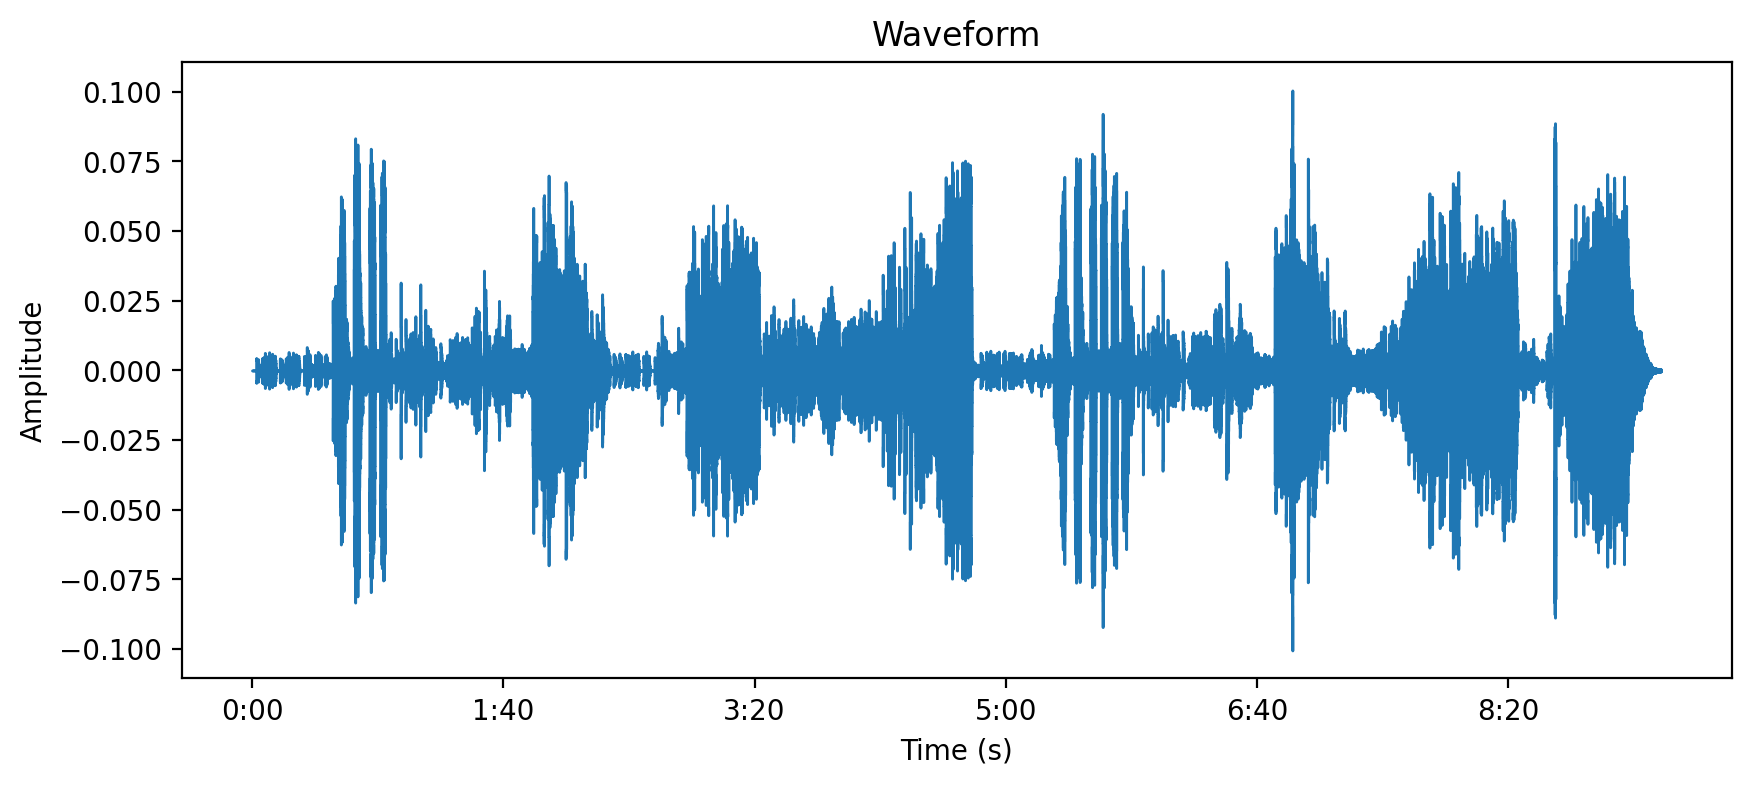

In [33]:
display_waveform(convert_midi_to_wav(df_beet["file_path"][0]))

In [34]:
beet_notes = []

for filename in df_beet["file_path"]:
    midi_file = pretty_midi.PrettyMIDI(filename)
    beet_notes.append(midi_to_notes(midi_file))

# flatten the data
beet_notes = pd.concat(beet_notes)
print(beet_notes)
print(f"Number of notes: {len(beet_notes)}")
beet_notes.describe()

     pitch        step  duration
0       60    0.000000  0.518640
1       56    0.518640  0.136599
2       53    0.655239  1.669347
3       56    2.324586  0.477331
4       60    2.801917  0.107427
..     ...         ...       ...
704     74  493.527434  0.064150
705     76  493.591584  0.063886
706     74  493.655470  0.065458
707     76  493.720928  0.065291
708     74  493.786219  0.064851

[53392 rows x 3 columns]
Number of notes: 53392


,pitch,step,duration
count,53392.000000,53392.000000,53392.000000
mean,72.281241,234.326694,0.275722
std,9.958246,161.380448,0.389276
min,30.000000,0.000000,0.006783
25%,65.000000,102.164442,0.093458
50%,73.000000,206.541131,0.125523
75%,79.000000,346.275893,0.288739
max,101.000000,758.100957,9.501601


In [35]:
train_beet_dataset = tf.data.Dataset.from_tensor_slices(beet_notes)
sequence_length = 16
vocab_size = 128
seq_dataset = generate_sequences(train_beet_dataset, sequence_length, vocab_size)
batch_size = 32
train_dataset = (seq_dataset
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
input_shape = (sequence_length, 3)
learning_rate = 0.005

inputs = keras.Input(input_shape, batch_size=batch_size)
x = keras.layers.LSTM(128)(inputs)
inputs.shape

(32, 16, 3)

In [37]:
model = keras.Model(inputs, outputs)
outputs = {
    'pitch': keras.layers.Dense(128, name='pitch')(x),
    'step': keras.layers.Dense(1, name='step')(x),
    'duration': keras.layers.Dense(1, name='duration')(x),
}
loss = {
      'pitch': keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_loss_positive_pressure,
      'duration': mse_loss_positive_pressure,
}

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='export/working/final_project2.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=0,
        restore_best_weights=True),
]
epochs = 5

history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5


1668/1668 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - duration_loss: 0.3291 - loss: 50145.0312 - pitch_loss: 4.0684 - step_loss: 50140.6289
Epoch 2/5
  15/1668 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - duration_loss: 0.2387 - loss: 77.3851 - pitch_loss: 4.0535 - step_loss: 73.0930

/home/basilp/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1668/1668 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - duration_loss: 0.2336 - loss: 20074.2676 - pitch_loss: 3.9584 - step_loss: 20070.0742
Epoch 3/5
  14/1668 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - duration_loss: 0.2125 - loss: 93.3804 - pitch_loss: 4.3375 - step_loss: 88.8304

2025-04-22 23:39:55.338727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4751967846933247099
2025-04-22 23:39:55.338752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9094504924181255779
2025-04-22 23:39:55.338755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2537225142587275209
2025-04-22 23:39:55.338757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15218254671524696026


1668/1668 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - duration_loss: 0.2551 - loss: 9176.3008 - pitch_loss: 3.9093 - step_loss: 9172.1436
Epoch 4/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - duration_loss: 0.1866 - loss: 6419.3267 - pitch_loss: 3.8913 - step_loss: 6415.2505
Epoch 5/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - duration_loss: 0.1934 - loss: 8020.9692 - pitch_loss: 3.8547 - step_loss: 8016.9175


In [38]:
NUM_PREDICTIONS = 120

sample_beet = pretty_midi.PrettyMIDI(df_beet["file_path"][5])
raw_notes = midi_to_notes(sample_beet)
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:sequence_length] / np.array([vocab_size, 1, 1]))

In [39]:
out_beet_file = 'output_beet.mid'
generated_beet_notes = music_generator(input_notes, NUM_PREDICTIONS)
instrument = midi_file.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

In [40]:
out_pm = notes_to_midi(generated_beet_notes, out_file=out_beet_file, instrument_name=instrument_name)

In [41]:
generated_beet_notes

,pitch,step,duration,start,end
0,79,11.603285,0.548968,11.603285,12.152253
1,79,11.098918,0.409526,22.702203,23.111729
2,50,9.568166,0.342829,32.270369,32.613198
3,57,9.212267,0.340586,41.482635,41.823222
4,47,8.504335,0.308107,49.986971,50.295078
...,...,...,...,...,...
115,73,0.000000,0.480124,74.063978,74.544102
116,85,0.000000,0.396307,74.063978,74.460285
117,33,0.000000,0.380538,74.063978,74.444516
118,33,0.000000,0.474265,74.063978,74.538244


In [42]:
convert_midi_to_wav(midi_file_path=out_beet_file, dest_file_path="output_beet", force=True)

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output_beet.wav'..


'output_beet.wav'

# Conclusion 
Does the conclusion include the following:
- Basic reiteration of results
- Discussion of learning and takeaways
- Discussion of why something didn’t work.
- Suggestions for ways to improve.